# InSituPy demonstration - Analyze data

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import scanpy as sc
from insitupy import read_xenium

## Previous steps

1. Download the example data for demonstration: [01_InSituPy_demo_download_data.ipynb](./01_InSituPy_demo_download_data.ipynb).
2. Register images from external stainings: [02_InSituPy_demo_register_images.ipynb](./02_InSituPy_demo_register_images.ipynb)

At this point, the structure of the data should look like this:

    ```
    ./demo_dataset
    ├───output-XETG00000__slide_id__sample_id
    │   ├───analysis
    │   │   ├───clustering
    │   │   ├───diffexp
    │   │   ├───pca
    │   │   ├───tsne
    │   │   └───umap
    │   └───cell_feature_matrix
    ├───registered_images
    ├───registration_qc
    └───unregistered_images
    ```


## Load Xenium data into `InSituData` object

Now the Xenium data can be parsed by providing the data path to the `InSituPy` project folder.

In [3]:
# prepare paths
data_dir = Path("demo_dataset/demo_insitupy_project/") # directory of xenium data
xd = read_xenium(data_dir)

In [4]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy

In [5]:
# read all data modalities at once
xd.load_all()

# alternatively, it is also possible to read each modality separately
# xd.load_cells()
# xd.load_images()
# xd.load_transcripts()
# xd.read_annotations()

Loading annotations...
No `annotations` modality found.
Loading cells...
	No alternative cells found...
Loading images...
Loading regions...
No `regions` modality found.
No `transcripts` modality found.


Note: That the `annotations` and `regions` modalities are not found here is expected. Annotations are added in a later step.

In [6]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       DAPI:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 167780 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nuclear

## Explore data in interactive `napari` viewer

Example image of the viewer:

<left><img src="./demo_screenshots/whole_napari_viewer.png" width="800"/></left>

For detailed documentation on the functionalities of `napari` see the official documentation [here](https://napari.org/stable/index.html).

In [7]:
xd.show()

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


### Explore gene expression using `napari` viewer

Use the `"Add cells"` widget to explore the single-cell transcriptomic data.

<left><img src="./demo_screenshots/add_cells.jpg" width="350"/></left>

Genes can be selected from the dropdown window by scrolling or by clicking into the window and typing the name of the item:

<left><img src="./demo_screenshots/select_gene.jpg" width="350"/></left>

After selection of an item it can be added using the `"Add"` button. The data is added as point layer to the napari viewer.

## Perform preprocessing steps

`InSituPy` also includes basic preprocessing functions to normalize the transcriptomic data and perform dimensionality reduction. For normalization, the ``ScanPy`` function `sc.pp.normalize_total()` is used. Data transformation can be either done using logarithmic transformation or square root transformation as suggested [here](https://stlearn.readthedocs.io/en/latest/tutorials/Xenium_PSTS.html).


### Filtering

In [8]:
sc.pp.filter_cells(xd.cells.matrix, min_genes=10)

c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Filtering of cells happens on the level of `.cells.matrix`. To synchronize the cells included in `.cells.matrix` after the filtering and their boundaries in `.cells.boundaries`, `.sync_cell_ids` can be called on `.cells`.

In [9]:
xd.cells.sync_cell_ids()

Successfully synchronized.


### Normalization and dimensionality reduction

Calculating the UMAP can take about 5 min due to the size of the dataset.

In [10]:
xd.normalize_and_transform(transformation_method="sqrt")
xd.reduce_dimensions(umap=True, tsne=False)

Store raw counts in anndata.layers['counts']...
Normalization, sqrt-transformation...
Dimensionality reduction...
Leiden clustering...


C:\Users\ge37voy\Github\InSituPy\insitupy\utils\preprocessing.py:112: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


### Show results using `scanpy` functions

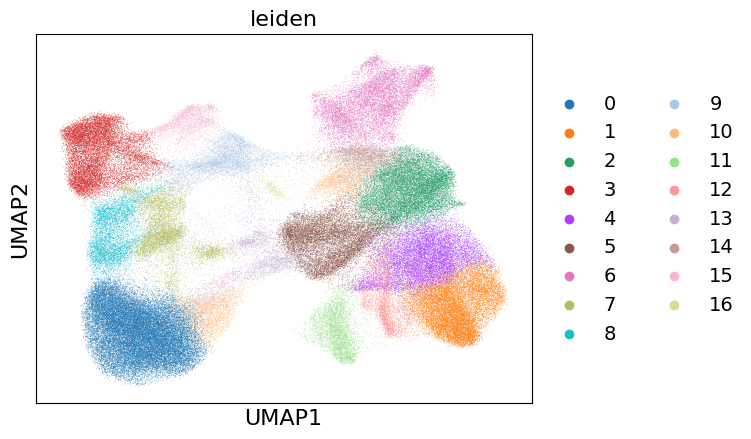

In [11]:
sc.pl.umap(xd.cells.matrix, color="leiden")

In [12]:
# visualize data
xd.show()

#### Start viewer with list of selected genes

Alternatively to selecting genes inside the napari viewer, it is also possible to open the viewer directly including a list of genes.

In [13]:
xd.show(keys=["leiden", "ACTA2", "LYZ", "LUM"])

Genes can be displayed or hidden via the eye symbol: <br>
<left><img src="./demo_screenshots/gene_selection.jpg" height="70"/></left>

## Save results within `InSituPy` project

The processed data can be saved into a folder using the `.saveas()` function of `InSituData`.

The resulting folder has following structure (can vary depending on which modalities have been loaded before):
```
insitupy_project_folder
│   .ispy
│
├───cells
│   └───uid
│       │   .celldata
│       │
│       ├───boundaries
│       │       cellular.zarr.zip
│       │       nuclear.zarr.zip
│       │
│       └───matrix
│               matrix.h5ad
│
├───images
│       morphology_mip.zarr.zip
│       slide_id__sample_id__CD20__registered.zarr.zip
│       slide_id__sample_id__HER2__registered.zarr.zip
│       slide_id__sample_id__HE__registered.zarr.zip
│
└───transcripts
        transcripts.parquet
```

In [14]:
xd.save()

Updating project in c:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
	Updating cells...
Saved.
Reloading following modalities: cells,images
Loading cells...
	No alternative cells found...
Loading images...
